In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp

# Basics of Continuation

## Ressources
- Lecture notes Hermann Riecke [pdf](https://www.researchgate.net/publication/228688534_Methods_of_Nonlinear_Analysis_412), [videos](https://youtu.be/VDtvmMSZZjI?si=th6DVQIRiyyPA9UP)
- Seydel. Practical bifurcation and stability analysis. (2009)
- Uecker. Continuation and Bifurcation in Nonlinear PDEs – Algorithms, Applications, and Experiments (2022)
- Kurt Lust PhD thesis on continuation of periodic orbits

## Main idea

Consider a dynamical system described by the following (system of coupled) ODE(s),

$$
\dfrac{d}{dt} \bm{u} = \bm{F}(\bm{u}, \eta),
$$

where $\bm{u}$ is the state vector and $\eta$ the control parameter. In the case of a PDE or integro-differential equation, it can be discretized in space and approximated by a system of ODEs,
corresponding to the above equation.

The main objective of numerical continuation, is to obtain both stable and unstable equilibria of the dynamical system as the parameters are varied (bifurcation diagram). In what follows, we will restrict the analysis to only steady states or fixed point, for simplicity. Nevertheless, the method can be extended to find limit cycles as well.


### Finding the equilibria

Steady states do not evolve in time, therefore they satisfy the following (system of nonlinear) equation(s),

$$
\bm{F}(\bm{u}, \eta) = 0.
$$

The above equation can be solved through various methods, the preferred one is Newton-Raphson's for its fast (quadratic) convergence and simplicity. Consider an initial guess $\bm{u}_0$ close enough to the 'true' solution, succesive points will be determined through the following Eqs.

$$
\bm{J}(\bm{u}_i, \eta) \Delta \bm{u}_{i+1} = -\bm{F}(\bm{u}_i, \eta) \\
\bm{u}_{i+1} = \bm{u}_i + \Delta \bm{u}_{i+1}
$$

Where $\bm{J}$ is the Jacobian of $\bm{F}$. Since the Jacobian is computed at each iteration, it can be used to find the stability and detect bifurcation points!

We now know how to find a solution for a fixed parameter value, let's see how it can be changed.


### Varying the parameter

The whole point of the continuation is to obtain the bifurcation diagram, i.e. the solution as the parameter is varied. There are several strategies, the simplest and most frequent are the following.

#### Natural parameter continuation

The most basic strategy would be to find the solution $\bm{u}_0$ for $\eta = \eta_0$, then take a small step $\Delta \eta$, and find the solution $\bm{u}_1$ for $\eta = \eta_0 + \Delta \eta$
using the previous solution as initial guess. 

Let's illustrate the method with a simple example, consider the imperfect pitchfork bifurcation with $\varepsilon = 1$.

$$
\dfrac{du}{dt} = \eta + \varepsilon u - u^3
$$

Find the solutions $u(\eta)$ for $\eta \in [-1, 1]$

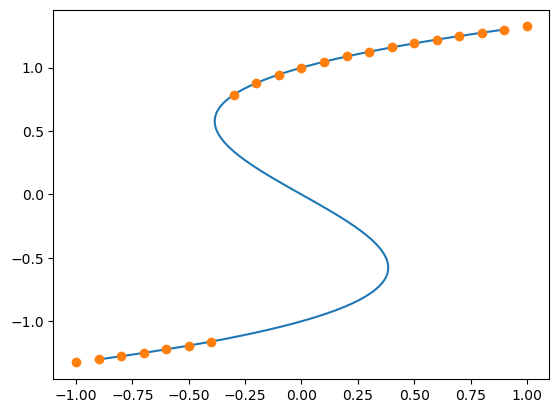

In [7]:
epsilon = 1

def exact_solution():
    us = np.linspace(-1.3, 1.3, 101)
    etas = -epsilon * us + us ** 3
    return etas, us

def F(u, eta):
    return eta + epsilon * u - u ** 3

def J(u, eta):
    return epsilon - 3 * u ** 2

def scalar_newton(u0, eta, atol=1e-6, max_iter=20):
    u = u0
    for i in range(max_iter):
        u_new = u - F(u, eta) / J(u, eta)
        if np.abs(u_new - u) < atol:
            return u
        u = u_new
    raise ValueError("Newton's method did not converge")

def continuation(u0, etas):
    us = np.zeros_like(etas)
    u = u0
    for k, eta in enumerate(etas):
        u = scalar_newton(u, eta)
        us[k] = u
    return us

etas_exact, us_exact = exact_solution()
plt.plot(etas_exact, us_exact, label='exact')

etas = np.linspace(-1, 1, 21)
us = continuation(1.4, etas[::-1])

plt.plot(etas[::-1], us, 'o', label='continuation')
plt.show()



It turns out that the control parameter is not necessarily the best way to parametrize the solution curve.

#### Pseudo-arclength continuation

The PALC algorithm aims to parametrize the solution curve by the arclength $s$, through a predictor-corrector method.

Consider we previously know a point of the solution branch $\bm{y}_0 = (\bm{u}_0, \eta_0)$ and the tangent at that point $\bm{\tau}_0$. 

1. *Predictor step*: Extrapolate a distance $\Delta s$ along the tangent $\bm{\tau}_0$ from the previously known point  $(\bm{u}_0, \eta_0)$ an use it as initial guess

$$
\bm{y} = \bm{y}_0 + \bm{\tau}_0 \Delta s
$$

2. *Corrector step*: Force the solution to stay at a distance $\Delta s$ in the plane perpendicular to the tangent.
$$
(\bm{y} - \bm{y}_0) \cdot \bm{\tau}_0 = \Delta s
$$

What is the tangent vector?

$$
\bm{\tau} = \dfrac{d}{ds} \bm{y} = \left(\dfrac{d\bm{u}}{ds}, \dfrac{d\eta}{ds}\right)^T
$$

How can we compute it? Recall that we want to solve the following equation. It is useful to write out the dependance on $s$,

$$
\bm{F}(\bm{u}(s), \eta(s)) = 0.
$$

Then take the derivative with respect to $s$,

$$
\bm{J}(\bm{u}(s), \eta(s)) \dfrac{d\bm{u}}{ds} + \bm{F}_\eta(\bm{u}(s), \eta(s)) \dfrac{d\eta}{ds} = 0.
$$

In order to find a unique solution to the above equation, we need to add another restriction: that the tangent is normalized. For this, it is convenient to fix $\dfrac{d\eta}{ds} = 1$ and then solve the above equation for $\dfrac{d\bm{u}}{ds}$,

$$
\bm{J}(\bm{u}(s), \eta(s)) \dfrac{d\bm{u}}{ds} = - \bm{F}_\eta(\bm{u}(s), \eta(s))
$$


Then, we normalize the tangent vector and choose its orientation such that it matches the orientation of the previous tangent, i.e. such that $\bm{\tau} \cdot \bm{\tau}_0 > 0$. In the first step where we don't have a previously known tangent, we can choose the orientation such that its last element is positive to move forward (in $\eta$) or negative to move backward.

To summarize, we need to solve the following extended system,

$$
\tilde{\bm{F}}(\bm{y}) = 
\begin{pmatrix}
\bm{F}(\bm{y}) \\
(\bm{y} - \bm{y}_0) \cdot \bm{\tau}_0 - \Delta s
\end{pmatrix}
= 0
$$

Its Jacobian is,
$$
\tilde{\bm{J}}(\bm{y}) =
\begin{pmatrix}
\bm{J} & \bm{F}_\eta \\
\dfrac{d\bm{u}}{ds} & \dfrac{d\eta}{ds}
\end{pmatrix}
$$

In [17]:
def F(y):
    u, eta = y
    return eta + epsilon * u - u ** 3

def J(y):
    u, eta = y
    return epsilon - 3 * u ** 2

def F_eta(y):
    return 1

def F_tilda(y, y0, tau0, ds):
    return np.append(F(y), np.dot(y - y0, tau0) - ds)

def J_tilda(y, y0, tau0):
    return np.array([[J(y), F_eta(y)], tau0])

def get_tangent(y, tau0):
    duds = -F_eta(y) / J(y)

    tau = np.append(duds, 1)
    if np.dot(tau, tau0) < 0:
        tau *= -1
    
    return tau / np.linalg.norm(tau)

def vector_newton(y0, tau0, ds, atol=1e-9, max_iter=20):
    y = y0.copy()
    for i in range(max_iter):
        y_new = y - np.linalg.solve(J_tilda(y, y0, tau0), F_tilda(y, y0, tau0, ds))
        if np.linalg.norm(y_new - y) < atol:
            return y
        y = y_new
    raise ValueError("Newton's method did not converge")

def palc_continuation(y0, etaf, ds, direction='forward', max_steps=1000):
    y = y0.copy()
    eta = y0[-1]
    ys = [y]
    tau0 = np.zeros_like(y)
    tau0[-1] = 1 if direction == 'forward' else -1
    for i in range(max_steps):
        tau0 = get_tangent(y, tau0)        
        y = vector_newton(y + ds * tau0, tau0, ds,atol=1e-8)
        ys.append(y)
        eta = y[-1]
        
        if direction == 'forward' and eta >= etaf:
            break
        if direction == 'backward' and eta <= etaf:
            break
    
    return np.array(ys)

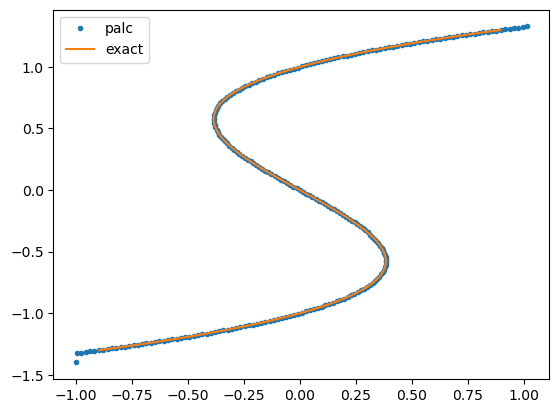

In [18]:
ys = palc_continuation(np.array([-1.4, -1.0]), 1, 0.01)
plt.plot(ys[:, 1], ys[:, 0], '.', label='palc')
plt.plot(etas_exact, us_exact, label='exact')
plt.legend()
plt.show()

Now let's see the case of a PDE: the cubic-quintic SHE

$$
\partial_t u = \varepsilon u + u ^ 3 - u ^ 5 - \nu \partial_{xx} u - \partial_{xxxx}u
$$

In [58]:
n_x = 512
dx = 0.25

def second_derivative(u, dx):
    return (np.roll(u, -1) - 2 * u + np.roll(u, 1)) / dx ** 2

def second_matrix_derivative(n_x, dx):
    diags = [1, 1, -2, 1, 1]
    offsets = [-n_x + 1,-1, 0, 1, n_x - 1]
    return sp.diags(diags, offsets, shape=(n_x, n_x), format='csc') / dx ** 2

D2 = second_matrix_derivative(n_x, dx)
D4 = D2 @ D2

def F(y):
    u, eta = y[:-1], y[-1]
    d2u = second_derivative(u, dx)
    d4u = second_derivative(d2u, dx)

    return eta * u + u ** 3 - u ** 5 - d2u - d4u

def J(y):
    u, eta = y[:-1], y[-1]
    diag = sp.diags(eta + 3 * u ** 2 - 5 * u ** 4, 0)

    return diag - D2 - D4

def F_eta(y):
    return y[:-1]

def F_tilda(y, y0, tau0, ds):
    return np.append(F(y), np.dot(y - y0, tau0) - ds)

def J_tilda(y, y0, tau0):
    jac = J(y)
    last_col = F_eta(y).reshape(n_x, 1)
    jac = sp.hstack([jac, last_col], format='csc')
    jac = sp.vstack([jac, tau0], format='csc')
    return jac

def get_tangent(y, tau0):
    duds = - sp.linalg.spsolve(J(y), F_eta(y))

    tau = np.append(duds, 1)
    if np.dot(tau, tau0) < 0:
        tau *= -1
    
    return tau / np.linalg.norm(tau)

def vector_newton(y0, tau0, ds, atol=1e-7, max_iter=20):
    y = y0.copy()
    for i in range(max_iter):
        y_new = y - sp.linalg.spsolve(J_tilda(y, y0, tau0), F_tilda(y, y0, tau0, ds))
        if np.linalg.norm(F_tilda(y, y0, tau0, ds)) / len(y) < atol:
            return y
        y = y_new
    raise ValueError("Newton's method did not converge")

def palc_continuation(y0, etaf, ds, direction='forward', max_steps=2000):
    y = y0.copy()
    eta = y0[-1]
    ys = [y]
    tau0 = np.zeros_like(y)
    tau0[-1] = 1 if direction == 'forward' else -1
    for i in range(max_steps):
        tau0 = get_tangent(y, tau0)        
        y = vector_newton(y + ds * tau0, tau0, ds, atol=1e-8)
        ys.append(y)
        eta = y[-1]
        
        if direction == 'forward' and eta >= etaf:
            break
        if direction == 'backward' and eta <= etaf:
            break
    
    return np.array(ys)

In [74]:
def first_derivative(u, dx):
    return (np.roll(u, -1) - np.roll(u, 1)) / (2 * dx)

def first_derivative_matrix(n_x, dx):
    diagonals = [1, -1, 1, -1]
    offsets = [-n_x+1, -1, 1, n_x-1]
    return sp.diags(diagonals, offsets, shape=(n_x, n_x), format='csc') / (2 * dx)

D1 = first_derivative_matrix(n_x, dx)

def F(y, y0, *args):
    u, c, epsilon = y[:-2], y[-2], y[-1]
    d2u = second_derivative(u, dx)
    d4u = second_derivative(d2u, dx)
    dF = epsilon * u + u ** 3 - u ** 5 - d2u - d4u + c * first_derivative(u, dx)
    return np.append(dF, dx * np.dot(u, first_derivative(y0[:-2], dx)))

def F_eta(y):
    u = y[:-2]
    return np.append(u, 0)

def F_c(y):
    u = y[:-2]
    return first_derivative(u, dx)

def J(y, y0, *args):
    u, c, epsilon = y[:-2], y[-2], y[-1]
    diag = sp.diags([epsilon + 3 * u ** 2 - 5 * u ** 4], [0], format='csc')
    jac = diag - D2 - D4 + c * D1

    pre_col = F_c(y)
    pre_col = pre_col.reshape(len(pre_col), 1)

    pre_row = np.append(first_derivative(y0[:-2], dx), 0) * dx

    jac = sp.hstack([jac, pre_col], format='csc')
    jac = sp.vstack([jac, pre_row], format='csc')
    return jac

def F_tilda(y, y0, tau0, ds):
    return np.append(F(y, y0), np.dot(y - y0, tau0) - ds)

def J_tilda(y, y0, tau0):
    # np.array([[jac(y), func_eta(y)], tau0])
    jac = J(y, y0)
    last_col = F_eta(y)
    last_col = last_col.reshape(len(last_col), 1)
    last_row = tau0

    jac = sp.hstack([jac, last_col], format='csc')
    jac = sp.vstack([jac, last_row], format='csc')

    return jac

def get_tangent(y, tau0):
    duds = - sp.linalg.spsolve(J(y, y), F_eta(y))

    tau = np.append(duds, 1)
    if np.dot(tau, tau0) < 0:
        tau *= -1
    
    return tau / np.linalg.norm(tau)

def vector_newton(y0, tau0, ds, atol=1e-7, max_iter=20):
    y = y0.copy()
    for i in range(max_iter):
        y_new = y - sp.linalg.spsolve(J_tilda(y, y0, tau0), F_tilda(y, y0, tau0, ds))
        if np.linalg.norm(F_tilda(y, y0, tau0, ds)) / len(y) < atol:
            return y
        y = y_new
    raise ValueError("Newton's method did not converge")

def palc_continuation(y0, etaf, ds, direction='forward', max_steps=2000):
    y = y0.copy()
    eta = y0[-1]
    ys = [y]
    tau0 = np.zeros_like(y)
    tau0[-1] = 1 if direction == 'forward' else -1
    for i in range(max_steps):
        tau0 = get_tangent(y, tau0)        
        y = vector_newton(y + ds * tau0, tau0, ds, atol=1e-8)
        ys.append(y)
        eta = y[-1]
        
        if direction == 'forward' and eta >= etaf:
            break
        if direction == 'backward' and eta <= etaf:
            break
    
    return np.array(ys)

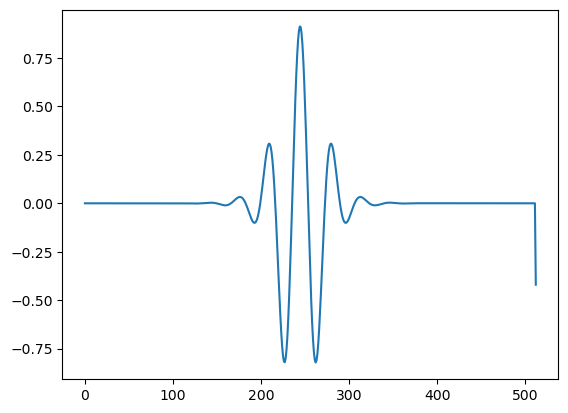

In [75]:
y = np.load('data/LS_sym.npy')
plt.plot(y)

In [76]:
u0, eta0 = y[:-1], y[-1]
y = np.append(u0, [0, eta0])

ys = palc_continuation(y, 0.1, 0.01, direction='forward')
l2 = np.linalg.norm(ys[:, :-1], axis=1) ** 2 / n_x

plt.plot(ys[:, -1], l2, label='palc')

(513, 513) (513,)


UnboundLocalError: local variable 'J' referenced before assignment

In [50]:
import pandas as pd
df = pd.DataFrame({
    'epsilon': ys[:, -1],
    'l2': l2
})
df.to_csv('data/pttrn.csv', index=False)